# Introducing the NONCOV Toolbox in Python

## Introduction

## Structure

## Load NONCOVToolbox Library

In [1]:
import sys
import os

path_noncov = os.path.abspath(os.path.join('..', 'src'))

if path_noncov not in sys.path:
    sys.path.append(path_noncov)

from noncov import NONCOVToolbox

noncov = NONCOVToolbox()



          #################################################
          | --------------------------------------------- |
          |         (NC)^2I.py: NMR Calculations          |
          |         for Noncovalent Interactions          |
          | --------------------------------------------- |
          |           Introducing: NONCOVToolbox          |
          |                       -                       |
          |     A collection of functions for working     |
          |         with calculated NMR parameters        |
          |                                               |
          |               Ettore Bartalucci               |
          |     Max Planck Institute CEC & RWTH Aachen    |
          |            Worringerweg 2, Germany            |
          |                                               |
          #################################################

Stable version: 0.0.1


Working python version:
3.12.0 (tags/v3.12.0:0fb18b0, Oct  2 2023, 13:03:

In [3]:
configdir = os.getcwd()
configdir = os.path.abspath(os.path.join('..', 'config'))
configs = os.path.join(configdir, 'configuration.yml')
print(f'Change with care, configuration file is in:', configs)

print('And looks like this...\n')
with open(configs,'r') as f:
    config_file = f.read()
    print(config_file)

Change with care, configuration file is in: d:\PhD\Data\DFT\NONCOV\DFT_simulations\codes\config\configuration.yml
And looks like this...

STRUCTURE =
SCRATCH =



In [4]:
current_dir = os.getcwd()
print(f'Current work directory is: {current_dir}')
scratch_dir = os.path.abspath(os.path.join('..', 'scratch'))
print(f'Current scratch directory is: {scratch_dir}')

Current work directory is: d:\PhD\Data\DFT\NONCOV\DFT_simulations\codes\results
Current scratch directory is: d:\PhD\Data\DFT\NONCOV\DFT_simulations\codes\scratch


## Modules: OrcaAnalysis

In [5]:
from noncov import OrcaAnalysis

In [6]:
# Example usage: "D:\PhD\Data\DFT\NONCOV\DFT_simulations\codes\tests\data\KLaL_cation_pi_RCCE_opt.mpi8.out"
orca_output = input("Enter the path to the ORCA file you want to work with: ")
orca_output = OrcaAnalysis().convert_path(orca_output)
scratch_dir = OrcaAnalysis().convert_path(scratch_dir)



          #################################################
          | --------------------------------------------- |
          |         (NC)^2I.py: NMR Calculations          |
          |         for Noncovalent Interactions          |
          | --------------------------------------------- |
          |           Introducing: NONCOVToolbox          |
          |                       -                       |
          |     A collection of functions for working     |
          |         with calculated NMR parameters        |
          |                                               |
          |               Ettore Bartalucci               |
          |     Max Planck Institute CEC & RWTH Aachen    |
          |            Worringerweg 2, Germany            |
          |                                               |
          #################################################

Stable version: 0.0.1


Working python version:
3.12.0 (tags/v3.12.0:0fb18b0, Oct  2 2023, 13:03:

In [7]:
# Inspect ORCA file and split
n_jobs = OrcaAnalysis().count_jobs_number(orca_output)
print(f'Number of ORCA jobs in file: {n_jobs}\n')

size_orca_output = os.path.getsize(orca_output)
size_orca_output = size_orca_output/1024
print(f'Size of ORCA file is: {size_orca_output} KB\n')

if n_jobs > 20:
    print(f'Careful, you are working with a possibly large output file of several GB\n')
    print(f'If using version controls consider setting up a .gitignore \n')

if size_orca_output > 1000:
    print(f"Careful, you are working with a '{size_orca_output}' KB large file..\n")
    print(f'Set up a .gitignore before pushing to Git\n')

# Extract level of theory
lot_out = OrcaAnalysis().extract_level_of_theory(orca_output)
print(f'Level of theory for the NMR calculations is: {lot_out}\n')

# Split orca output in several subfiles
if n_jobs > 2:
    print('Your output file will be now spilt into subfiles. \n')
    OrcaAnalysis().split_orca_output(scratch_dir, orca_output)



          #################################################
          | --------------------------------------------- |
          |         (NC)^2I.py: NMR Calculations          |
          |         for Noncovalent Interactions          |
          | --------------------------------------------- |
          |           Introducing: NONCOVToolbox          |
          |                       -                       |
          |     A collection of functions for working     |
          |         with calculated NMR parameters        |
          |                                               |
          |               Ettore Bartalucci               |
          |     Max Planck Institute CEC & RWTH Aachen    |
          |            Worringerweg 2, Germany            |
          |                                               |
          #################################################

Stable version: 0.0.1


Working python version:
3.12.0 (tags/v3.12.0:0fb18b0, Oct  2 2023, 13:03:

In [12]:
# --- Define boundary distance ranges in NONCOV --- #
# Define the boundaries ([A]) for various noncovalent interactions
OrcaAnalysis().run_boundary_checks()



          #################################################
          | --------------------------------------------- |
          |         (NC)^2I.py: NMR Calculations          |
          |         for Noncovalent Interactions          |
          | --------------------------------------------- |
          |           Introducing: NONCOVToolbox          |
          |                       -                       |
          |     A collection of functions for working     |
          |         with calculated NMR parameters        |
          |                                               |
          |               Ettore Bartalucci               |
          |     Max Planck Institute CEC & RWTH Aachen    |
          |            Worringerweg 2, Germany            |
          |                                               |
          #################################################

Stable version: 0.0.1


Working python version:
3.12.0 (tags/v3.12.0:0fb18b0, Oct  2 2023, 13:03:

In [13]:
# --- Extract the various CSA tensor components --- #
# Initialize displacement steps in Angstrom - need to find a clever way to do this
displacement_steps_distance = [job * 0.25 for job in range(1,n_jobs+1)]

In [38]:
import os
import matplotlib.pyplot as plt

def plot_shifts(S_tot, nuclear_identities, displacement_steps_distance, 
                min_distance_value, max_distance_value, scratch_dir):
    """
    Plots the diagonal components of the shielding tensor for each nucleus.
    
    :param S_tot: List of dictionaries with shielding tensor components.
    :param nuclear_identities: List of lists of nuclear identity strings (keys).
    :param displacement_steps_distance: List of displacement steps.
    :param min_distance_value: Minimum distance value for shading the NONCOV effective region.
    :param max_distance_value: Maximum distance value for shading the NONCOV effective region.
    :param scratch_dir: Directory to save the plots.
    """
    # Create a folder to save the shifts plots as PDFs and JPEGs if it doesn't exist
    shifts_figures_folder = os.path.join(scratch_dir, 'OrcaAnalysis/shifts_plot')
    os.makedirs(shifts_figures_folder, exist_ok=True)

    # Plot the shielding parameters for each nucleus
    for nucleus_list in nuclear_identities:
        for nucleus_key in nucleus_list:
            # Extract shielding values for the current nucleus from each dictionary
            nucleus_values_S11 = []
            nucleus_values_S22 = []
            nucleus_values_S33 = []
            nucleus_values_Siso = []

            for d in S_tot:
                if isinstance(d, dict):
                    tensor = d.get(nucleus_key)
                    if tensor and len(tensor) == 3 and all(len(row) == 3 for row in tensor):
                        nucleus_values_S11.append(tensor[0][0])
                        nucleus_values_S22.append(tensor[1][1])
                        nucleus_values_S33.append(tensor[2][2])
                    else:
                        print(f"Unexpected tensor shape for nucleus '{nucleus_key}' or data not found.")
                else:
                    print(f"Unexpected type in S_tot: {type(d)}")

            if len(nucleus_values_S11) == 0:
                print(f"No data available for nucleus '{nucleus_key}'")
                continue

            # Calculate isotropic shielding
            nucleus_values_Siso = [(S11 + S22 + S33) / 3 for S11, S22, S33 in zip(nucleus_values_S11, nucleus_values_S22, nucleus_values_S33)]

            # Split the nucleus_key into a tuple (nucleus number, element) if needed
            nucleus = tuple(nucleus_key.split())

            # Plot the shielding values for the current nucleus
            plt.plot(displacement_steps_distance, nucleus_values_S11, marker='o', linestyle='-', color='darkblue', label=r'$\sigma$_11')
            plt.plot(displacement_steps_distance, nucleus_values_S22, marker='o', linestyle='-', color='orangered', label=r'$\sigma$_22')
            plt.plot(displacement_steps_distance, nucleus_values_S33, marker='o', linestyle='-', color='gold', label=r'$\sigma$_33')
            plt.plot(displacement_steps_distance, nucleus_values_Siso, marker='*', linestyle='-', color='magenta', label=r'$\sigma$_iso')

            # Highlight the NONCOV effective region
            plt.axvspan(min_distance_value, max_distance_value, alpha=0.2, color='grey', label='NONCOV \n effective region')
            
            # Set labels and title
            plt.xlabel('Displacement from initial geometry / Å')
            plt.ylabel('Shielding / ppm')
            plt.title(f'Nucleus {nucleus[1]} {nucleus[2]}')
            
            # Display legend
            plt.legend(loc='best')
            
            # Save the plot as a PDF in the output folder
            pdf_filename = os.path.join(shifts_figures_folder, f'nucleus_{nucleus[1]}_{nucleus[2]}.pdf')
            plt.savefig(pdf_filename, bbox_inches='tight')

            # Save the plot as a JPEG in the output folder
            jpg_filename = os.path.join(shifts_figures_folder, f'nucleus_{nucleus[1]}_{nucleus[2]}.jpg')
            plt.savefig(jpg_filename, bbox_inches='tight')
            
            # Show the plot (optional, can be commented out if you don't want to display the plots)
            #plt.show()

            # Clear the current figure for the next iteration
            plt.clf()


In [54]:
import os
import matplotlib.pyplot as plt

def plot_tensor_shielding(S_dia, S_para, S_tot, nuclear_identities, 
                          displacement_steps_distance, min_distance_value, max_distance_value, 
                          scratch_dir, iteration):
    """
    Plots tensor shielding values (diamagnetic, paramagnetic, and total) for each nucleus.

    :param S_dia: List of dictionaries with diamagnetic tensor components.
    :param S_para: List of dictionaries with paramagnetic tensor components.
    :param S_tot: List of dictionaries with total tensor components.
    :param nuclear_identities_2: List of nuclear identity strings.
    :param displacement_steps_distance: List of displacement steps.
    :param min_distance_value: Minimum distance value for shading the NONCOV effective region.
    :param max_distance_value: Maximum distance value for shading the NONCOV effective region.
    :param scratch_dir: Directory to save the plots.
    :param iteration: Current iteration number (used for filename).
    """
    # Create a folder to save the tensor plots as PDFs and JPEGs if it doesn't exist
    pas_tensors_figures_folder = os.path.join(scratch_dir, 'OrcaAnalysis/tensor_plots')
    os.makedirs(pas_tensors_figures_folder, exist_ok=True)

    # Loop over each nucleus identity and plot its tensor shielding values
    for nucleus_list in nuclear_identities:
        for nucleus_key in nucleus_list:
            if isinstance(nucleus_key, list):
                nucleus_key = "_".join(map(str, nucleus_key))
                
            # Extract individual contributions to shielding values for the current nucleus from each dictionary
            nucleus_values_S_dia = [d.get(nucleus_key, [])[0] for d in S_dia]
            nucleus_values_S_para = [d.get(nucleus_key, [])[0] for d in S_para]
            nucleus_values_S_tot = [d.get(nucleus_key, [])[0] for d in S_tot]

            # Split the nucleus_key into a tuple (nucleus number, element)
            nucleus = tuple(nucleus_key.split())

            # Plot the shielding values for the current nucleus
            plt.plot(nucleus_values_S_dia, marker='o', linestyle='-', color='darkblue', label=r'$\sigma$_dia_11')
            plt.plot(nucleus_values_S_para, marker='o', linestyle='-', color='orangered', label=r'$\sigma$_para_11')
            plt.plot(nucleus_values_S_tot, marker='o', linestyle='-', color='gold', label=r'$\sigma$_tot_11')

            # Highlight the NONCOV effective region (optional, can be commented out if not needed)
            plt.axvspan(min_distance_value, max_distance_value, alpha=0.2, color='grey', label='NONCOV \n effective region')
            
            # Set labels and title
            plt.xlabel('Displacement from initial geometry / Å')
            plt.ylabel('Shielding / ppm')
            plt.title(f'Nucleus {nucleus[1]} {nucleus[2]} - Iteration {iteration}')
            
            # Display legend
            plt.legend(loc='best')
            
    # Save the plot as a PDF in the output folder
    pdf_filename = os.path.join(pas_tensors_figures_folder, f'nucleus_{nucleus[1]}_iteration_{iteration}.pdf')
    plt.savefig(pdf_filename, bbox_inches='tight')

    # Save the plot as a JPEG in the output folder
    jpg_filename = os.path.join(pas_tensors_figures_folder, f'nucleus_{nucleus[1]}_iteration_{iteration}.jpg')
    plt.savefig(jpg_filename, bbox_inches='tight')
    
    # Show the plot (optional, can be commented out if you don't want to display the plots)
    #plt.show()

    # Clear the current figure for the next iteration
    plt.clf()


In [55]:
# Initialize variables for shielding tensor components
S_dia = []
S_para = []
S_tot = []
nuclear_identities = []

# Extract NMR data from each splitted file
for job_number in range (1, n_jobs+1): # split files = number of jobs
        
    # All splitted outputs from main big .out MPI8 file
    orca_splitted_output = os.path.join(scratch_dir, 'OrcaAnalysis/split_orca_output', f'splitted_orca_job{job_number}.out')

    # Extract CSA data
    shielding_dia, shielding_para, shielding_tot, nucleus_info = OrcaAnalysis().extract_csa_data(orca_splitted_output)
    
    # Append xx,yy,zz shielding tensor components (non-diagonalized)
    S_dia.append(shielding_dia)
    S_para.append(shielding_para)
    S_tot.append(shielding_tot)
    nuclear_identities.append(nucleus_info)
    
    plot_tensor_shielding(S_dia, S_para, S_tot, nuclear_identities, displacement_steps_distance, 0, 5, scratch_dir, job_number)



          #################################################
          | --------------------------------------------- |
          |         (NC)^2I.py: NMR Calculations          |
          |         for Noncovalent Interactions          |
          | --------------------------------------------- |
          |           Introducing: NONCOVToolbox          |
          |                       -                       |
          |     A collection of functions for working     |
          |         with calculated NMR parameters        |
          |                                               |
          |               Ettore Bartalucci               |
          |     Max Planck Institute CEC & RWTH Aachen    |
          |            Worringerweg 2, Germany            |
          |                                               |
          #################################################

Stable version: 0.0.1


Working python version:
3.12.0 (tags/v3.12.0:0fb18b0, Oct  2 2023, 13:03:

ValueError: Image size of 583x77297 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 583x77297 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 640x480 with 1 Axes>

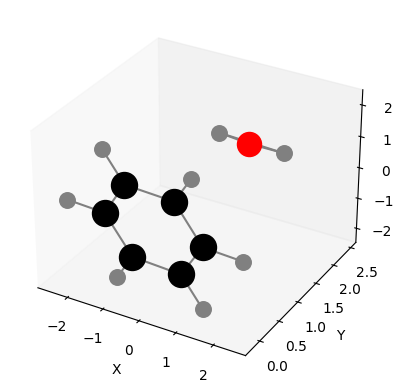

In [57]:
molecule = 'D:/PhD/Data/DFT/NONCOV/DFT_simulations/codes/scratch/test_structs/benzene_H2O.xyz'

OrcaAnalysis.plot_3d_molecule(molecule)

## Modules: NMRFunctions

In [ ]:
# Test zone
xx =-5.9766
xy =-65.5206
xz =-9.5073
yx =-60.3020
yy =-23.0881
yz =-28.2399
zx =-10.8928
zy =-25.2372
zz =56.277

shielding_tensor, diagonal_mehring, diagonal_haberlen, eigenvals, eigenvecs, symmetry = NMRFunctions.diagonalize_tensor(xx, xy, xz, yx, yy, yz, zx, zy, zz)
mode = 'PZYZ'
order = 1
alpha, beta, gamma = NMRFunctions.tensor_to_euler(shielding_tensor, eigenvals, eigenvecs, symmetry, 'PZYZ')



## Modules: MolecularGraph

In [ ]:
def main(molecule_path):

    mol_graph = MolecularGraph()

    # Parse the XYZ file
    atom_types, coordinates = mol_graph.parse_xyz(molecule_path)
    
    # Calculate pairwise distances
    distances = mol_graph.calculate_distances(coordinates)
    
    # Detect covalent bonds
    covalent_bonds = mol_graph.detect_bonds(atom_types, distances)
    
    # Detect non-covalent interactions
    noncovalent_interactions = mol_graph.detect_noncovalent_interactions(atom_types, distances)
    
    # Build the molecular graph
    #mol_graph = mol_graph.build_molecular_graph(atom_types, coordinates, covalent_bonds, noncovalent_interactions)
    
    # Visualize the molecular graph
    #mol_graph.draw()

    # Plots 
    mol_graph.plot_bond_dist_matrix(covalent_bonds, distances, atom_types)
    mol_graph.plot_noncov_distance_map(noncovalent_interactions, atom_types)

    # Build different graphs
    covalent_bonds_graph = mol_graph.build_covalent_bonds_graph(atom_types, coordinates, covalent_bonds)
    intramolecular_graph = mol_graph.build_intramolecular_graph(atom_types, coordinates, covalent_bonds, noncovalent_interactions)
    intermolecular_graph = mol_graph.build_intermolecular_graph(atom_types, coordinates, noncovalent_interactions)

    # Draw subplots while preserving atom positions
    mol_graph.draw_subplots(covalent_bonds_graph, intramolecular_graph, intermolecular_graph, coordinates)




threshold = 1.6

current_dir = os.getcwd()
print(f'Current working directory is: {current_dir}')
#molecule = os.path.join(current_dir, 'scratch/test_structs/caffeine.xyz')

molecule = 'D:/PhD/Data/DFT/NONCOV/DFT_simulations/codes/scratch/test_structs/benzene_H2O.xyz'

main(molecule)


## Modules: DistanceScanner & RotationScanner

In [ ]:
# WORKING WITH RELATIVE PATHS 
current_dir = os.getcwd()
print(current_dir)

# LOGS AND ERRORS
error_log_file = 'error_log_file.txt' # to finish
log_file = 'log_file.txt' # to finish


# START TIMER: COMPUTE EFFECTIVE WALL TIME
start = timer() # this is not in [sec] i think

# SECTON: MAIN
def main():

    # Relative paths
    start_structure = os.path.join(current_dir, 'input_structures/KLaL_cation_pi_RCCE_opt_NICS.xyz')
    centroid_out = os.path.join(current_dir, 'centroid_output/centroid_file.xyz')
    input_file = os.path.join(current_dir, 'input_file/input_file.txt')

    # Read xyz file: this should be either a fully optimized geometry or one with relaxed H
    coordinates, atom_identities = read_atomic_coord(start_structure)
    print(f'Starting coordinates: {coordinates}')
    print(f'Atom identities: {atom_identities}')

    # Assign coordinates to molecular fragments, check nomenclature of your atoms in avogadro or any other molecular graphics soft
    coords1, coords2 = assign_molecule_fragments(coordinates, input_file)

    # Concatenate coordinates for k-means clustering
    all_coords = np.concatenate((coords1, coords2), axis=0)
    # print(f'All coords: {all_coords}')

    # Count how many fragments you have defined in the input file, important for accurate K-means clustering
    n_fragments = count_fragments(input_file)
    print(f"Number of '$fragment' occurrences: {n_fragments}")

    # Perform k-means clustering to compute centroids
    kmeans = KMeans(n_clusters=n_fragments) # K-means clusters = number of centroids = number of fragments
    kmeans.fit(all_coords)
    centroids = kmeans.cluster_centers_

    # Compute centroids for each fragment
    fragment_centroids = calculate_centroids([coords1, coords2])

    # Write centroid coordinates to file
    write_centroids(centroid_out, fragment_centroids)
    print(f'Centroid coordinates: {fragment_centroids}')

    # Calculate displacement direction (line connecting centroids)
    displacement_direction = centroids[1] - centroids[0]
    displacement_direction /= np.linalg.norm(displacement_direction)
    print(f'Displacement direction:{displacement_direction}')

    # Read displacement step size from input file
    displacement_step = None
    with open(input_file, 'r') as f:
        lines = f.readlines()
        read_displacement = False
        for line in lines:
            if read_displacement:
                displacement_values = line.strip().split()
                if displacement_values:
                    displacement_step = float(displacement_values[0])
                    break
            elif line.strip() == "$displacement":
                read_displacement = True

    if displacement_step is None:
        print('ERROR: displacement step size not found in input file, please specify it! Syntax => $displacement + number')
        return
    print(f'Displacement step is: {displacement_step}') # please doublecheck that it is the same value you defined in the input

    # Displace the first fragment iteratively and save each structure
    displaced_fragment_coords = coords1.copy()  # Make a copy of the original coordinates of the fragment that is displaced
    print(f'Original coordinates displaced fragment:', displaced_fragment_coords)

    # Initialize the coordinates for the fixed fragment (e.g., coords2)
    coords_fixed = coords2.copy() # make a copy of the fixed fragment coordinates to append to the displaced ones
    print(f'Original coordinates fixed fragment:', coords_fixed)

    all_displaced_fragment_coords = [displaced_fragment_coords]  # List to store all displaced structures

    # Combine displaced coordinates with original ones
    all_combined_coords = [np.concatenate((coords_fixed, displaced_fragment_coords), axis=0)]  # List to store all combined structures

    fragment_centroids = [fragment_centroids[0]]  # List to store all centroids

    # Dissociation limit NEED AT LEAST 40 OF THEM MINIMUM
    diss_lim = 50 # change with the output value in agnstrom from func(dissociation_limit)

    for i in range(1, diss_lim):  # Iterate 50 times (adjust the number as needed) put this as to be the dissociation limit of each DFT run
        
        displacement_vector = [] 

        # Compute new set of coordinates for displaced fragments, change $displacement value in input file to tune the displacement
        displaced_fragment_coords = displace_fragment(coords1, displacement_direction, displacement_step, i)
        #print(f'Displaced fragment coord is: {displaced_fragment_coords}')

        combined_coords = np.concatenate((coords_fixed, displaced_fragment_coords), axis=0)
        all_combined_coords.append(combined_coords)

        # Update centroids for the displaced structure
        fragment_centroid = calculate_centroids([displaced_fragment_coords])
        fragment_centroids.append(fragment_centroid[0])
        print(f'Updated centroids:', fragment_centroid)

        # Write displaced structure to file
        output_file = Path(os.path.join(current_dir, f'displaced_structures/displaced_structure_{i}.xyz'))
        write_displaced_xyz_file(output_file, coords_fixed, displaced_fragment_coords, atom_identities)

        all_displaced_fragment_coords.append(displaced_fragment_coords)

        # Compute distance between the fixed fragment centroid and all the atoms from the displaced fragment
        centroid_to_displaced_distance = compute_distance_from_centroid(displaced_fragment_coords, centroids)
        print(f'Distance between displaced coordinates and centroid is: {centroid_to_displaced_distance}')

        # Write distances to file - needed for DFT calculations outputs
        distance_output_file = Path(os.path.join(current_dir, f'distance_files/distances_structures_{i}.xyz'))
        write_distances_file(distance_output_file, displaced_fragment_coords, centroid_to_displaced_distance, atom_identities, displacement_step)


    # Plot initial topology for molecular fragments and centroids
    fig = plot_starting_molecular_fragments(coords1, coords2, centroids)

    # Generate colors for the plots based on displacement iteration
    num_iterations = len(all_displaced_fragment_coords)
    colors = plt.cm.viridis(np.linspace(0.2, 1.0, num_iterations))

    # Plot displaced molecular fragments and centroids
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot original fragments and centroids
    ax.scatter(coords1[:, 0], coords1[:, 1], coords1[:, 2], color=colors[0], label='Molecule 1 (Original)')
    ax.scatter(coords2[:, 0], coords2[:, 1], coords2[:, 2], color=colors[0], label='Molecule 2 (Original)')
    ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], color=colors[0], marker='x', s=100, label='Centroids (Original)')

    # Plot displaced fragments and centroids
    for i, displaced_coords in enumerate(all_displaced_fragment_coords[1:], start=1):
        color = colors[i]
        label = f'Iteration {i}'
        ax.scatter(displaced_coords[:, 0], displaced_coords[:, 1], displaced_coords[:, 2], color=color, label=label)
        ax.scatter(fragment_centroids[i][0], fragment_centroids[i][1], fragment_centroids[i][2], color=color, marker='x', s=100, label=f'Centroids ({label})')

    ax.legend()
    plt.show()


    # END TIMER: STOP TIMER AND PRINT
    elapsed_time = timer() - start  # in seconds
    print(f'Elapsed time for the code to run is: {elapsed_time}')


if __name__ == '__main__':
    main()


## Modules: GenerateMLDataset

In [ ]:
# def main():

# current_dir = os.getcwd()
# print(f'Current working directory is: {current_dir}')

# root_directory = os.path.join(current_dir, 'Machine_learning/raw')
# print(f'Dataset root directory is: {root_directory}')

# output_csv_path = os.path.join(current_dir, 'Machine_learning/datasets/model_structures/test.csv')
# print(f'Dataset directory is: {output_csv_path}')

# generate_dataset = GenerateMLDataset(root_directory, output_csv_path)
# generate_dataset.search_files()

# if __name__ == "__main__":
# main()

## Modules: AminoStat

In [ ]:
# # Example usage
# toolbox = NONCOVToolbox()
# amino_stats = toolbox.AminoStat()

# # Example usage
# current_dir = os.getcwd()

# protein_sequence = os.path.join(current_dir, 'scratch/amino_acid_stats/spidersilks.txt')
# spaced_sequence = os.path.join(current_dir, 'scratch/amino_acid_stats/spaced_spidersilks.txt')
# count_file = os.path.join(current_dir, 'scratch/amino_acid_stats/silks_amino_acid_count.txt')
# plot_file = os.path.join(current_dir, 'scratch/amino_acid_stats/silks_amino_acid_statistics.pdf')

# #amino_stats = AminoStat()

# amino_stats.space_prot_seq(protein_sequence, spaced_sequence)
# amino_stats.count_amino_acids(spaced_sequence, count_file)
# amino_stats.plot_amino_acid_statistics(count_file, plot_file)

# amino_stats.define_protein_domains()


## Preliminary results